<a href="https://colab.research.google.com/github/WaheedMomna/Assignment2/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [1]:
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
from collections import Counter
import torch.utils.data as data
import cv2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
%matplotlib inline
from torchsummary import summary
import torch.nn as nn
import torchvision.models as models



Set up device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Extract Data

In [ ]:
!tar -xvf '/content/drive/MyDrive/A2/CS867 Sp2022_A2_Dataset/train_and_val_set.tar'

Prepare Dataset

In [7]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define a dictionary to convert expressions to integers
expressions_dict = {'Neutral': 0, 'Happy': 1, 'Sad': 2, 'Surprise': 3, 'Fear': 4, 'Disgust': 5, 'Anger': 6, 'Contempt': 7}

# Define a dictionary to map suffixes to variable names
suffixes_dict = {'_exp.npy': 'expression', '_aro.npy': 'arousal', '_val.npy': 'valence'}

class FaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.annotation_dir = os.path.join(root_dir, 'annotations')
        self.image_suffix = '.jpg'
        
        self.image_names = os.listdir(self.image_dir)
        self.annotation_names = [name.replace(self.image_suffix, '') for name in self.image_names]
        self.transform = transform
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        annotation_name = self.annotation_names[idx]
        
        # Load the image
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path)
        
        # Load the annotations
        annotation = {}
        for suffix, var_name in suffixes_dict.items():
            path = os.path.join(self.annotation_dir, annotation_name + suffix)
            if os.path.exists(path):
                annotation[var_name] = np.load(path, allow_pickle=True).item()
        
        if not annotation:
            print(f"No annotations found for {image_name}")
            return None
        
        # Check if expression label is valid
        expression_label = annotation.get('expression')
        # if expression_label is None or int(expression_label) not in expressions_dict:
        #     print(expression_label,': ',f"Unknown or missing expression label for {image_name}\n")
            
        #     return None
        
        # Get the values of the annotations
        expression = expression_label
        expression = int(expression)
        arousal = float(annotation.get('arousal'))
        valence = float(annotation.get('valence'))


        
        # Apply transform if provided
        if self.transform:
            image = self.transform(image)
        
        # Convert the annotations to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float)
        expression = torch.tensor(expression, dtype=torch.long)
        arousal = torch.tensor(arousal, dtype=torch.float)
        valence = torch.tensor(valence, dtype=torch.float)
        
        return image, expression, arousal, valence


# Define the transforms to apply to the images
transform = transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((224,224))])

# Define the train dataset and data loader
dataset = FaceDataset('/content/train_set', transform=transform)

# Filter out examples with errors
#dataset = [d for d in dataset if d is not None]

# Calculate dataset sizes


# Calculate dataset sizes
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Split dataset into training and validation sets
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoader instances
train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True, 
    num_workers=2)

val_loader = DataLoader(
    val_dataset, 
    batch_size=64,
    shuffle=True, 
    num_workers=2)


Check shape of a batch of data

In [8]:

images, expression, arousal, valence = next(iter(train_loader))

# Denormalize the images (undo the normalization done in the transform)
#denormalized_images = images * torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)

# Print the shape of the images and labels
print(images.shape)
print(expression.shape)
print(arousal.shape)
print(valence.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

torch.Size([64, 3, 224, 224])
torch.Size([64])
torch.Size([64])
torch.Size([64])


Visualize exmaples from data

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

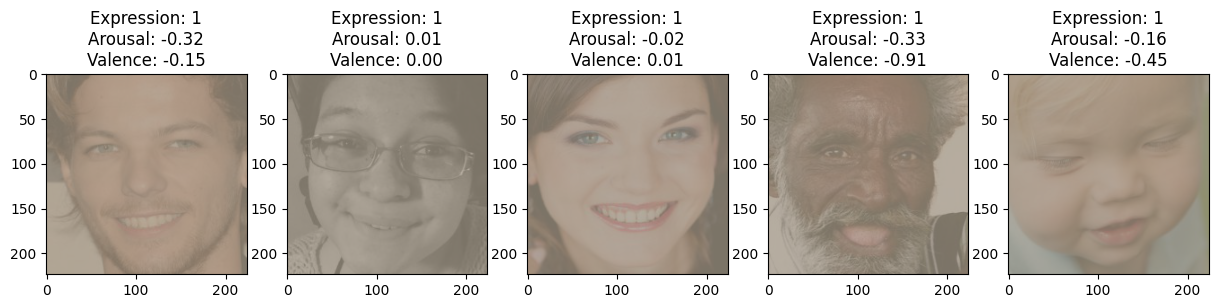

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Get the first 5 images and their labels
images, expression_labels, arousal_labels, valence_labels = next(iter(train_loader))
images = images[:5]
expression_labels = expression_labels[:5]

# Denormalize the images (undo the normalization done in the transform)
denormalized_images = images * torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)

# Convert expression labels from tensors to numpy arrays
expression_labels = expression_labels.numpy()

# Plot the images and their labels
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
for i in range(5):
    # Transpose the image tensor to (height, width, channels) format for plotting
    img = denormalized_images[i].permute(1, 2, 0).numpy()
    ax[i].imshow(img)
    ax[i].set_title(f"Expression: {expression_labels[i]}\nArousal: {arousal[i]:.2f}\nValence: {valence[i]:.2f}")
    #labels = [f"{expressions_dict_rev[expression[i]]}\nArousal: {arousal[i]:.2f}\nValence: {valence[i]:.2f}" for i in range(64)]
plt.show()
#expressions_dict = {'Neutral': 0, 'Happy': 1, 'Sad': 2, 'Surprise': 3, 'Fear': 4, 'Disgust': 5, 'Anger': 6, 'Contempt': 7}

Prepare custom classifier and trainer classes

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class CustomClassifier(nn.Module):
    def __init__(self, in_features, num_classes_exp, num_classes_av):
        super(CustomClassifier, self).__init__()
        self.fc_exp = nn.Linear(in_features, num_classes_exp)
        self.fc_av = nn.Linear(in_features, num_classes_av)
        
    def forward(self, x):
        out_exp = self.fc_exp(x)
        out_av = self.fc_av(x)
        return out_exp, out_av

class ResNet18(nn.Module):
    def __init__(self, num_classes_exp=8, num_classes_av=2):
        super(ResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        
        # Freeze layers
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Unfreeze last few layers
        layers_to_unfreeze = ['layer4', 'avgpool']
        for name, child in self.resnet.named_children():
            if name in layers_to_unfreeze:
                for param in child.parameters():
                    param.requires_grad = True
        # Get the number of input features to the final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        
        # Replace the final fully connected layer with a new one with the desired number of classes
        self.resnet.fc = CustomClassifier(num_ftrs, num_classes_exp, num_classes_av)
    
    def forward(self, x):
        out = self.resnet(x)
        return out




class Trainer():
    def __init__(self, model, class_criterion, reg_criterion, optimizer, device):
        self.model = model
        self.class_criterion = class_criterion
        self.reg_criterion = reg_criterion
        self.optimizer = optimizer
        self.device = device

    
    def accuracy_av(self, output_av, target_arousal, target_valence):
      pred_arousal, pred_valence = output_av[:, 0], output_av[:, 1]
      diff_arousal = pred_arousal - target_arousal
      diff_valence = pred_valence - target_valence
      rmse_arousal = torch.sqrt(torch.mean(diff_arousal**2))
      rmse_valence = torch.sqrt(torch.mean(diff_valence**2))
      return rmse_arousal, rmse_valence
    
    def train(self, train_loader):
        self.model.train()
        train_loss = 0
        correct_exp = 0
        rmse_arousal = 0
        rmse_valence = 0
            
        for batch_idx, (data, target_exp, target_arousal, target_valence) in enumerate(tqdm(train_loader)):
            data, target_exp, target_arousal, target_valence = data.to(self.device), target_exp.to(self.device), target_arousal.to(self.device), target_valence.to(self.device)
            self.optimizer.zero_grad()
            output_exp, output_av = self.model(data)
            loss_exp = self.class_criterion(output_exp, target_exp)
            loss_av = self.reg_criterion(output_av, torch.stack((target_arousal, target_valence), dim=1))
            loss = loss_exp + loss_av
            train_loss += loss.item()
            pred_exp = output_exp.argmax(dim=1, keepdim=True)
            correct_exp += pred_exp.eq(target_exp.view_as(pred_exp)).sum().item()
            rmse_ar, rmse_val = self.accuracy_av(output_av, target_arousal, target_valence)
            rmse_arousal += rmse_ar.item()
            rmse_valence += rmse_val.item()
                
            loss.backward()
            self.optimizer.step()
            
        train_loss /= len(train_loader.dataset)
        accuracy_exp = 100. * correct_exp / len(train_loader.dataset)
        rmse_arousal /= len(train_loader.dataset)
        rmse_valence /= len(train_loader.dataset)
        return train_loss, accuracy_exp, rmse_arousal, rmse_valence

    def validate(self, val_loader):
      self.model.eval()
      val_loss = 0
      correct_exp = 0
      rmse_arousal = 0
      rmse_valence = 0
      
      with torch.no_grad():
          for data, target_exp, target_arousal, target_valence in val_loader:
              data, target_exp, target_arousal, target_valence = data.to(self.device), target_exp.to(self.device), target_arousal.to(self.device), target_valence.to(self.device)
              output_exp, output_av = self.model(data)
              loss_exp = self.class_criterion(output_exp, target_exp)
              loss_av = self.reg_criterion(output_av, torch.stack((target_arousal, target_valence), dim=1))
              loss = loss_exp + loss_av
              val_loss += loss.item()
              pred_exp = output_exp.argmax(dim=1, keepdim=True)
              correct_exp += pred_exp.eq(target_exp.view_as(pred_exp)).sum().item()
              rmse_ar, rmse_val = self.accuracy_av(output_av, target_arousal, target_valence)
              rmse_arousal += rmse_ar
              rmse_valence += rmse_val
      val_loss /= len(val_loader.dataset)
      accuracy_exp = 100. * correct_exp / len(val_loader.dataset)
      rmse_arousal /= len(val_loader.dataset)
      rmse_valence /= len(val_loader.dataset)
      return val_loss, accuracy_exp, rmse_arousal, rmse_valence











Initialize Parameters for model

In [7]:
# Select a loss function
class_loss = torch.nn.CrossEntropyLoss()
regression_loss = nn.MSELoss()

model= ResNet18().to(device);

# Select an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
# For more on schedulers please visit:
# https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863

# Set the number of epochs
# This variable is used in the main training loop
epochs = 10




Original Model

In [9]:
print(models.resnet18(pretrained=True))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Modified Model

In [8]:
model

ResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [15]:

# Initializing variables for starting a new training
# Some helper variables

num_epochs = 10
learning_rate = 0.001
momentum = 0.9
weight_decay = 1e-4
batch_size = 32
num_classes = 8

# Create ResNet18 model and move it to device
model = ResNet18().to(device)


# Define loss function and optimizer
class_criterion = nn.CrossEntropyLoss()
reg_criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)


train_accuracy_exp_list = []
train_rms_ar_list = []
train_rms_val_list = []
val_accuracy_exp_list = []
val_rms_ar_list = []
val_rms_val_list = []


train_loss_list = []
val_loss_list = []


val_accuracy_max_exp = -1
val_rms_min_ar = 2
val_rms_min_val = 2



checkpoint_path = '/content/drive/MyDrive/A2/Copy of checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint_path = '/content/drive/MyDrive/A2/Copy of best_val_checkpoint_norm_aug_tensorboard.pth'

# Start epoch is zero for new training
start_epoch = 0

Run this block after the above block to start training from scratch

In [27]:
import warnings
warnings.filterwarnings("ignore")

# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Train model for one epoch

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  trainer = Trainer(model=model, class_criterion=class_criterion,reg_criterion=reg_criterion, optimizer=optimizer, device=device)

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, accuracy_exp, rmse_arousal, rmse_valence  = trainer.train(train_loader)

  # Update the learning rate scheduler
  scheduler.step()

  train_accuracy_exp_list.append(accuracy_exp)
  train_rms_ar_list.append(rmse_arousal)
  train_rms_val_list.append(rmse_valence)
  train_loss_list.append(train_loss)
  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy_exp, val_rmse_arousal, val_rmse_valence  = trainer.validate(val_loader)
  
  # Lists for val loss and accuracy for plotting
  val_accuracy_exp_list.append(val_accuracy_exp)
  val_rms_ar_list.append(val_rmse_arousal)
  val_rms_val_list.append(val_rmse_valence)
  val_loss_list.append(val_loss)



  print('train loss: %.4f'%(train_loss))
  print('train_accuracy exp %.2f' % (accuracy_exp))
  print('train_rms arosal %.2f' % (rmse_arousal))
  print('train_rms Valance %.2f' % (rmse_valence))
  print('val loss: %.4f'%(val_loss))
  print('Val_accuracy exp %.2f' % (val_accuracy_exp))
  print('Val_rms arosal %.2f' % (val_rmse_arousal))
  print('Val_rms Valance %.2f' % (val_rmse_valence))
  
  # Save model if validation accuracy for current epoch is greater than 
  # all the previous epochs 
  if val_accuracy_exp >= val_accuracy_max_exp and val_rms_min_ar >= val_rmse_arousal and val_rms_min_val >= val_rmse_valence :
    val_accuracy_max_exp = val_accuracy_exp
    val_rms_min_ar = val_rmse_arousal
    val_rms_min_val = val_rmse_valence
    print('New Max Expression accuracy and Min Valence & Arousal RMSE for Validation acheived. Saving model.\n\n')

    checkpoint = {
      'model': model.state_dict(),
      'optimizer': optimizer.state_dict(),
      'scheduler': scheduler.state_dict(),
      'trianed_epochs': epoch,
      'train_losses': train_loss_list,
      'train_accuracy_exp': train_accuracy_exp_list,
      'train_rms_val': train_rms_val_list,
      'train_rms_ar': train_rms_ar_list,
      'val_losses': val_loss_list,
      'val_expression_accuracies': val_accuracy_exp_list,
      'val_rms_val': val_rms_val_list,
      'val_rms_ar': val_rms_ar_list,
      'val_accuracy_max_exp': val_accuracy_max_exp,
      'val_rmse_val_min': val_rms_min_val,
      'val_rmse_aro_min': val_rms_min_ar,
      'lr': optimizer.param_groups[0]['lr']
      }
    torch.save(checkpoint, best_val_checkpoint_path)
  else:
      print("val accuracy and RMSEs did not improve.\n\n")
      checkpoint = {
      'model': model.state_dict(),
      'optimizer': optimizer.state_dict(),
      'scheduler': scheduler.state_dict(),
      'trianed_epochs': epoch,
      'train_losses': train_loss_list,
      'train_accuracy_exp': train_accuracy_exp_list,
      'train_rms_val': train_rms_val_list,
      'train_rms_ar': train_rms_ar_list,
      'val_losses': val_loss_list,
      'val_expression_accuracies': val_accuracy_exp_list,
      'val_rms_val': val_rms_val_list,
      'val_rms_ar': val_rms_ar_list,
      'val_accuracy_max_exp': val_accuracy_max_exp,
      'val_rmse_val_min': val_rms_min_val,
      'val_rmse_aro_min': val_rms_min_ar,
      'lr': optimizer.param_groups[0]['lr']
      }
      torch.save(checkpoint, checkpoint_path)
 


Epoch 3: Train 
Learning Rate: 0.001000


  0%|          | 0/3596 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9c3f52050>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9c3f52050>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  0%|          | 1/3596 [00:00<53:19,  1.12it/s]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_

Epoch 3: Validation



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9c3f52050>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9c3f52050>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    self._shutdown_workers()if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process    
if w.is_alive():
  File "/usr/lib

train loss: 0.0119
train_accuracy exp 76.05
train_rms arosal 0.00
train_rms Valance 0.00
val loss: 0.0116
Val_accuracy exp 76.45
Val_rms arosal 0.00
Val_rms Valance 0.00
New Max Expression accuracy and Min Valence & Arousal RMSE for Validation acheived. Saving model.


Epoch 4: Train 
Learning Rate: 0.001000


  0%|          | 0/3596 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9c3f52050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9c3f52050>
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

    if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._par

Epoch 4: Validation



Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9c3f52050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9c3f52050>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processself._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib

train loss: 0.0110
train_accuracy exp 77.99
train_rms arosal 0.00
train_rms Valance 0.00
val loss: 0.0118
Val_accuracy exp 76.61
Val_rms arosal 0.00
Val_rms Valance 0.01
val accuracy and RMSEs did not improve.


Epoch 5: Train 
Learning Rate: 0.001000


  0%|          | 0/3596 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9c3f52050>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9c3f52050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

    if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3

Epoch 5: Validation



Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9c3f52050>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fc9c3f52050>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        if w.is_alive():
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only t

train loss: 0.0099
train_accuracy exp 80.26
train_rms arosal 0.00
train_rms Valance 0.00
val loss: 0.0121
Val_accuracy exp 75.96
Val_rms arosal 0.00
Val_rms Valance 0.00
val accuracy and RMSEs did not improve.


Epoch 6: Train 
Learning Rate: 0.001000


100%|██████████| 3596/3596 [20:58<00:00,  2.86it/s]

Epoch 6: Validation


train loss: 0.0086
train_accuracy exp 83.07
train_rms arosal 0.00
train_rms Valance 0.00
val loss: 0.0130
Val_accuracy exp 74.95
Val_rms arosal 0.00
Val_rms Valance 0.01
val accuracy and RMSEs did not improve.


Epoch 7: Train 
Learning Rate: 0.001000


100%|██████████| 3596/3596 [20:59<00:00,  2.85it/s]

Epoch 7: Validation


train loss: 0.0071
train_accuracy exp 86.53
train_rms arosal 0.00
train_rms Valance 0.00
val loss: 0.0142
Val_accuracy exp 73.65
Val_rms arosal 0.00
Val_rms Valance 0.00
val accuracy and RMSEs did not improve.


Epoch 8: Train 
Learning Rate: 0.001000


100%|██████████| 3596/3596 [20:55<00:00,  2.86it/s]


Epoch 8: Validation
train loss: 0.0055
train_accuracy exp 90.10
train_rms arosal 0.00
train_rms Valance 0.00
val loss: 0.0162
Val_accuracy exp 72.62
Val_rms arosal 0.00
Val_rms Valance 0.00
val accuracy and RMSEs did not improve.


Epoch 9: Train 
Learning Rate: 0.001000


100%|██████████| 3596/3596 [20:56<00:00,  2.86it/s]

Epoch 9: Validation


train loss: 0.0042
train_accuracy exp 93.22
train_rms arosal 0.00
train_rms Valance 0.00
val loss: 0.0179
Val_accuracy exp 73.28
Val_rms arosal 0.00
Val_rms Valance 0.00
val accuracy and RMSEs did not improve.




Run this block to load the checkpoint and then run the above bloack to resume training from checkpoint

In [16]:
# Loading all variables from a checkpoint to continue a training

# Path to checkpoint
#last model
saved_checkpoint_path = '/content/drive/MyDrive/A2/Copy of checkpoint_norm_aug_tensorboard.pth'
#best model
#saved_checkpoint_path = '/content/drive/MyDrive/CV A2/best_val_checkpoint_norm_aug_tensorboard.pth'

# Load the checkpoint
checkpoint = torch.load(saved_checkpoint_path)
print(checkpoint.keys())

# Load all the state_dictionaries of the model, optimizer and schedular
model.load_state_dict(checkpoint['model'])

optimizer.load_state_dict(checkpoint['optimizer'])

scheduler.load_state_dict(checkpoint['scheduler'])

# Epoch to continue from the last training
start_epoch = checkpoint['trianed_epochs'] + 1

# Load the accuracy and loss lists for record keeping
train_accuracy_exp_list = checkpoint['train_accuracy_exp']
train_rms_val_list = checkpoint['train_rms_val']
train_rms_ar_list = checkpoint['train_rms_ar']

val_accuracy_exp_list = checkpoint['val_expression_accuracies']
val_rms_val_list = checkpoint['val_rms_val']
val_rms_ar_list = checkpoint['val_rms_ar']

train_loss_list = checkpoint['train_losses']
val_loss_list = checkpoint['val_losses']

# Load the value of the max val accuracy obtained in the previous training
# This will help us to avoid saving a new model with lower val accuracy 
# over the previously saved model with better val accuracy
val_accuracy_max_exp = checkpoint['val_accuracy_max_exp']
val_rms_min_val = checkpoint['val_rmse_val_min']
val_rms_min_ar = checkpoint['val_rmse_aro_min']

# paths to checkpoint and best val acc model
checkpoint_path = 'checkpoint.pth'
best_val_checkpoint_path = 'best_val_checkpoint.pth'

dict_keys(['model', 'optimizer', 'scheduler', 'trianed_epochs', 'train_losses', 'train_accuracy_exp', 'train_rms_val', 'train_rms_ar', 'val_losses', 'val_expression_accuracies', 'val_rms_val', 'val_rms_ar', 'val_accuracy_max_exp', 'val_rmse_val_min', 'val_rmse_aro_min', 'lr'])


In [25]:
print(val_rms_min_ar)

tensor(0.0041, device='cuda:0')


In [15]:
start_epoch

3

Visualize training performance

Text(0.5, 1.0, 'Training and val Loss')

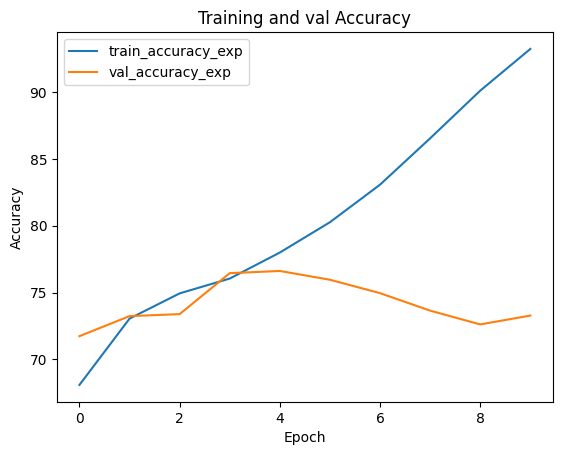

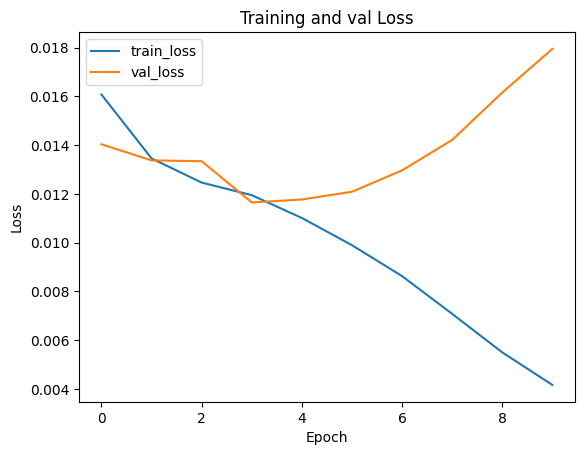

In [28]:
plt.figure()
plt.plot(train_accuracy_exp_list, label="train_accuracy_exp")
plt.plot(val_accuracy_exp_list, label="val_accuracy_exp")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and val Accuracy')

plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.plot(val_loss_list, label="val_loss")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and val Loss')

Prepare function of performance measures and perform testing and visualize it

In [1]:
from sklearn.metrics import auc

def auc_fn(predictions, labels):
  # convert preds and labs to numpy arrays
  preds = np.array(predictions)
  labs = np.array(labels)

  # calculate the one-hot encoding of the labels
  n_classes = len(np.unique(labs))
  one_hot_labs = np.zeros((len(labs), n_classes))
  one_hot_labs[np.arange(len(labs)), labs] = 1

  # calculate the ROC curve and AUC for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(one_hot_labs[:, i], preds == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

  # calculate the average AUC across all classes
  avg_auc = np.mean(list(roc_auc.values()))
  return avg_auc
  


In [37]:

import numpy as np

def nominal_distance(x, y):
    return x != y

def krippendorff_alpha(y_true, y_pred):
    # Calculate the pairwise distance matrix
    n = len(y_true)
    dist_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_mat[i,j] = nominal_distance(y_true[i], y_true[j])
            dist_mat[j,i] = dist_mat[i,j]
    
    # Calculate the observed agreement
    obs_agr = np.mean(np.array(y_true) == np.array(y_pred))
    
    # Calculate the expected agreement
    exp_agr = 0
    for i in range(n):
        for j in range(i+1, n):
            exp_agr += dist_mat[i,j] == nominal_distance(y_pred[i], y_pred[j])
    exp_agr /= (n*(n-1)/2)
    
    # Calculate alpha
    alpha_krippendorff = 1 - (obs_agr / exp_agr)
    return alpha_krippendorff


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
<ipython-input-7-2fa366eab2c6>:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float)
/usr/

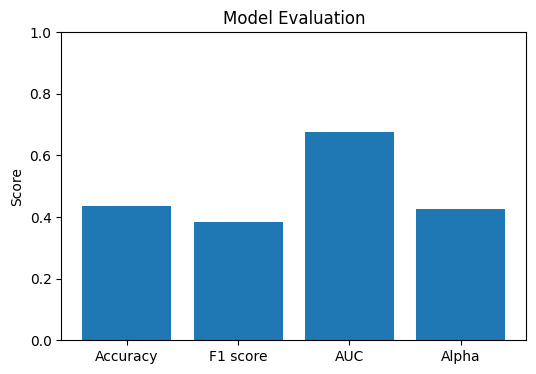

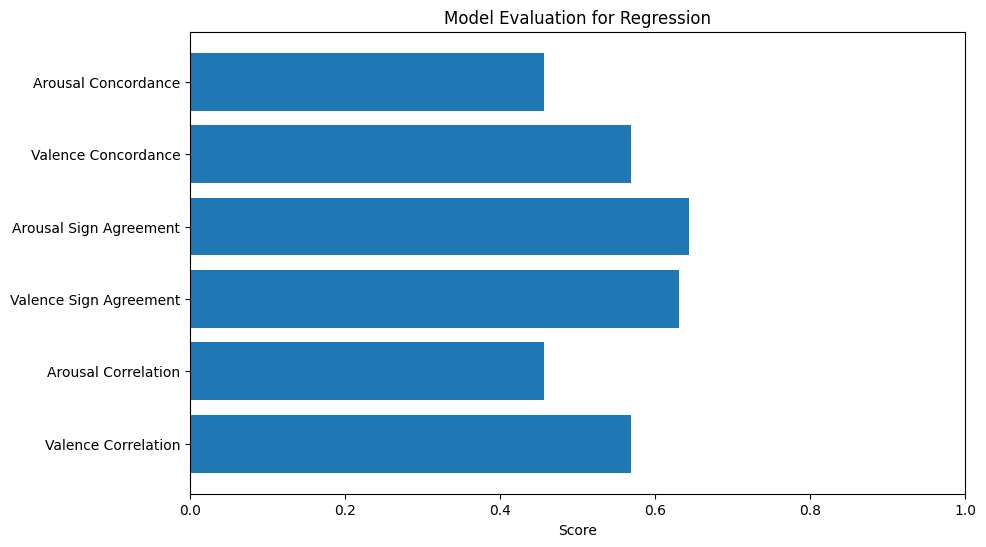

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import pearsonr, linregress
import numpy as np


# Load the best validation checkpoint
best_val_model_path = '/content/drive/MyDrive/A2/Copy of best_val_checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint = torch.load(best_val_model_path, map_location=torch.device(device))
model.load_state_dict(best_val_checkpoint['model'])

# Evaluate the model on the validation dataset
test_dataset = FaceDataset('/content/val_set', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)

y_true = []
y_pred = []
arousal_pred =[]
valence_pred =[]
arousal_true =[]
valence_true =[]
with torch.no_grad():
  for images, expression, arousal, valence in test_loader:
      output_exp, output_av = model(images.to(device))
      y_true.extend(expression.detach().cpu().numpy())
      y_pred.extend(torch.argmax(output_exp, axis=1).detach().cpu().numpy())
      arousal_pred.extend(output_av[:, 0].detach().cpu().numpy())
      valence_pred.extend(output_av[:, 1].detach().cpu().numpy())
      arousal_true.extend(arousal.detach().cpu().numpy())
      valence_true.extend(valence.detach().cpu().numpy())

# Compute accuracy and F1 score
acc = accuracy_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred, average='weighted')
auc_pr = auc_fn(y_pred,y_true)
alpha_krippendorff = krippendorff_alpha(y_true, y_pred)
# Compute Pearson correlation coefficient for valence and arousal
valence_corr, _ = pearsonr(valence_true, valence_pred)
arousal_corr, _ = pearsonr(arousal_true, arousal_pred)

# Compute sign agreement metric for valence and arousal
valence_sign_agreement = np.mean(np.sign(valence_true- np.median(valence_true)) == np.sign(valence_pred - np.median(valence_pred)))
arousal_sign_agreement = np.mean(np.sign(arousal_true - np.median(arousal_true)) == np.sign(arousal_pred - np.median(arousal_pred)))

# Compute concordance correlation coefficient for valence and arousal
valence_concordance = linregress(valence_true, valence_pred).rvalue
arousal_concordance = linregress(arousal_true, arousal_pred).rvalue


# Plot accuracy and F1 score
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(['Accuracy', 'F1 score','AUC','Alpha'], [acc, f1score,auc_pr,alpha_krippendorff])
ax.set_ylim([0, 1])
ax.set_ylabel('Score')
ax.set_title('Model Evaluation')
plt.show()


# Plot performance measures
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(['Valence Correlation', 'Arousal Correlation', 'Valence Sign Agreement', 'Arousal Sign Agreement', 'Valence Concordance', 'Arousal Concordance'],
       [valence_corr, arousal_corr, valence_sign_agreement, arousal_sign_agreement, valence_concordance, arousal_concordance])
ax.set_xlim([0, 1])
ax.set_xlabel('Score')
ax.set_title('Model Evaluation for Regression')
plt.show()
